In [1]:
using Flux
using JLD
using PyPlot

code_path = "../src"

push!(LOAD_PATH, code_path)
using AnomalyDetection

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
X = dataset.data
Y = dataset.labels
nX = X[:, Y.==0]

2×90 Array{Float64,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [3]:
# VAE settings
indim = size(X,1)
hiddendim = 10
latentdim = 2
nlayers = 2

# setup the VAE object
esize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
dsize = [latentdim; hiddendim; hiddendim; indim] # decoder architecture
lambda = 0.01 # KLD weight in loss function
threshold = 0 # classification threshold, is recomputed during fit!()
contamination = size(Y[Y.==1],1)/size(Y, 1) # for automatic threshold computation
iterations = 2000
cbit = 500 # after this number of iteratiosn, callback is printed
verbfit = true
L = 1 # samples for training and classification 
# set low for training but high for classification
activation = Flux.relu
rdelta = 1e-3 # reconstruction error threshold for training stopping
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples
tracked = true # do you want to store training progress?
# it can be later retrieved from model.traindata
model = VAEmodel(esize, dsize, lambda, threshold, contamination, iterations, cbit, verbfit, 
    L, activation = activation, rdelta = rdelta, Beta = Beta, tracked = tracked)

AnomalyDetection.VAEmodel(AnomalyDetection.VAE{Flux.Chain,AnomalyDetection.#sample_z,Flux.Chain}(Chain(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu)), Dense(10, 4)), AnomalyDetection.sample_z, Chain(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu)), Dense(10, 2))), 0.01, 0, 0.1262135922330097, 2000, 500, true, 1, 0.001, 1.0, Dict{Any,Any}())

In [4]:
# fit the model
AnomalyDetection.evalloss(model, nX)
AnomalyDetection.fit!(model, X, Y)
AnomalyDetection.evalloss(model, nX)

loss: 0.561527929107746
reconstruction error: 0.5578040029060003
KL: 0.4121341304911595

loss: 0.025504262749060817
reconstruction error: 0.011929342487469713
KL: 1.5502677867867096

loss: 0.02428293000467992
reconstruction error: 0.005495942172299876
KL: 1.4519999369407057

loss: 0.01743254471393488
reconstruction error: 0.0048794716914636075
KL: 1.3693322076579497

loss: 0.01818785366152875
reconstruction error: 0.0053156883766244094
KL: 1.286449715299593

loss: 0.018514176211494593
reconstruction error: 0.005939488523020632
KL: 1.286449715299593



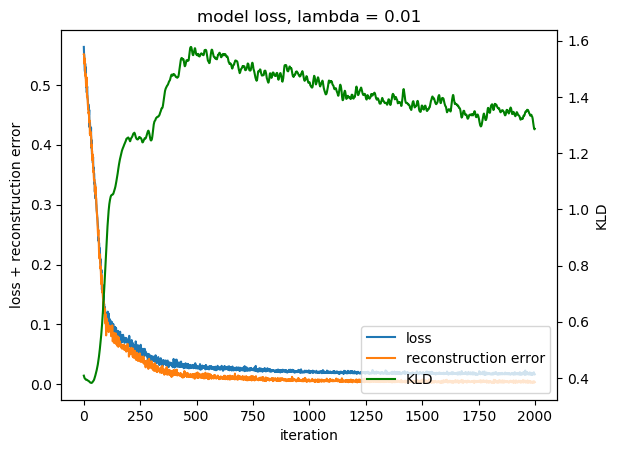

In [5]:
# plot model loss
if tracked
    figure()
    title("model loss, lambda = $(model.lambda)")
    y1, = plot(model.traindata["loss"], label = "loss")
    y2, = plot(model.traindata["reconstruction error"], label = "reconstruction error")
    ax = gca()
    ylabel("loss + reconstruction error")
    xlabel("iteration")
    
    ax2 = ax[:twinx]()
    y3, = plot(model.traindata["KLD"], label = "KLD", c = "g")
    ylabel("KLD")
    legend([y1, y2, y3], ["loss", "reconstruction error", "KLD"])
    show()
end

In [6]:
model(nX)

Tracked 2×90 Array{Float64,2}:
 0.806623  0.74106   0.732336  0.775062  …  0.0462473  0.0475262  0.0451517
 0.819425  0.759334  0.760421  0.792873     0.984904   0.982809   0.97499  

In [7]:
nX

2×90 Array{Float64,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [8]:
AnomalyDetection.mu(model, nX)

Tracked 2×90 Array{Float64,2}:
 0.0249568  0.0234743  0.0253442  …  -0.0289551  -0.0279779  -0.0266008
 1.19291    1.19599    1.20382       -0.916037   -0.915812   -0.912883 

In [9]:
AnomalyDetection.sigma(model, nX)

Tracked 2×90 Array{Float64,2}:
 1.01117   1.01255   1.01158   1.01388   …  0.951857  0.95402   0.951517
 0.216283  0.216087  0.215695  0.213738     0.34319   0.342126  0.343171

In [10]:
AnomalyDetection.sample_z(model, nX)

Tracked 2×90 Array{Float64,2}:
 0.823297  -0.566111  1.38577  2.04171  …  -0.228571  -0.295562  -0.124786
 0.781464   1.06078   1.03162  1.51587     -0.790897  -0.857007  -1.288   

In [11]:
# predict labels
model.L = 100 # number of samples - for classification higher is better (more stable)
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 0
 1
 1
 1
 0
 1
 1
 1
 1

In [12]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 11
  tn = 90
  fp = 0
  fn = 2
precision: 1.0
recall: 0.8461538461538461
f1score: 0.9166666666666666
equal error rate: 0.07692307692307693

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 12
  tn = 90
  fp = 0
  fn = 1
precision: 1.0
recall: 0.9230769230769231
f1score: 0.96
equal error rate: 0.038461538461538464


In [13]:
using ScikitLearn.Utils: meshgrid

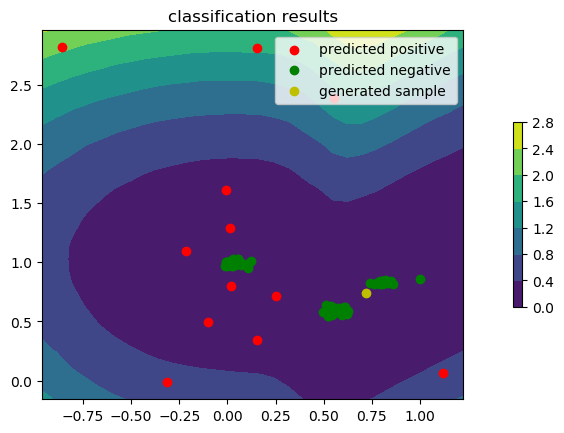

In [14]:
# plot heatmap of the fit
figure()
title("classification results")
scatter(X[1, tstyhat.==1], X[2, tstyhat.==1], c = "r")
ax = gca()
ylim = ax[:get_ylim]()
xlim = ax[:get_xlim]()
xx, yy = meshgrid(linspace(xlim[1], xlim[2], 30), linspace(ylim[1], ylim[2], 30))
zz = zeros(size(xx))
for i in 1:size(xx, 1)
    for j in 1:size(xx, 2)
        zz[i,j] = AnomalyDetection.rerr(model, [xx[i,j], yy[i,j]]).tracker.data
    end
end
axsurf = ax[:contourf](xx, yy, zz)
cb = colorbar(axsurf, fraction = 0.05, shrink = 0.5, pad = 0.1)
scatter(X[1, tstyhat.==1], X[2, tstyhat.==1], c = "r", label = "predicted positive")
scatter(X[1, tstyhat.==0], X[2, tstyhat.==0], c = "g", label = "predicted negative")
b = AnomalyDetection.generate(model)
scatter(b[1], b[2], c = "y", label = "generated sample")
legend(loc = "upper right")
show()

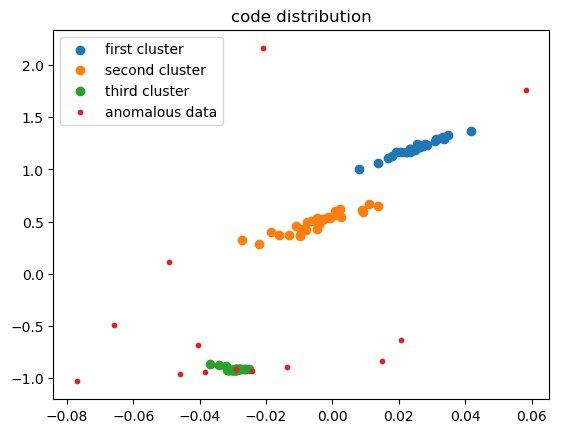

In [15]:
# what are the codes?
figure()
title("code distribution")
z1 = model.vae.encoder(X[:,1:30]).data
z2 = model.vae.encoder(X[:,31:60]).data
z3 = model.vae.encoder(X[:,61:90]).data
za = model.vae.encoder(X[:,91:end]).data

scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 10, label = "anomalous data")
legend()
show()